<a href="https://colab.research.google.com/github/Erech2020/DeepLearning/blob/master/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 1.x
%cd /content/drive/My Drive/ColabNotebooks
#%ls
%pwd

TensorFlow 1.x selected.
/content/drive/My Drive/ColabNotebooks


'/content/drive/My Drive/ColabNotebooks'

In [0]:
import tensorflow as tf
tf.version

<module 'tensorflow._api.v1.version' from '/tensorflow-1.15.2/python3.6/tensorflow_core/_api/v1/version/__init__.py'>

In [0]:
#!unzip validacion.zip 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from tensorflow import keras  #import keras
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation, Conv2D, MaxPool2D
#from tensorflow.keras import utils #import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras import backend as k
from tensorflow.keras.applications import densenet, vgg16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
np.random.seed(2)
k.clear_session()
ruta_data_entrenamiento = './data/entrenamiento'
ruta_data_validacion = './data/validacion'

epocas=18
longitud, altura = 150, 150 
batch_size = 12  # numero mínimo de imágenes de cada clase
pasos = 1000
validation_steps = 200
nclases = 242
lr = 0.01

In [0]:
entrenamiento_datagen = ImageDataGenerator(rescale = 1./ 255)
validacion_datagen = ImageDataGenerator(rescale = 1. / 255)

entrenamiento_generador = entrenamiento_datagen.flow_from_directory(
    ruta_data_entrenamiento,       #ruta de la carpeta de imagenes entrenamiento
    target_size=(altura, longitud),
    color_mode='rgb',
    batch_size=batch_size,    #número de imágenes que se generarán desde el generador por lote
    class_mode='categorical', #para mas de dos clases
    shuffle = True, 
    seed = 42)

validacion_generador = validacion_datagen.flow_from_directory(
    ruta_data_validacion,     #ruta de la carpeta de imagenes validacion
    target_size=(altura, longitud),
    color_mode='rgb',
    batch_size=1,
    class_mode='categorical',  #None, para devolver solo las imágenes
    shuffle = False,           #se requiere mostrar en orden las imagenes de salida
    seed = 42) 


Found 19700 images belonging to 242 classes.
Found 8296 images belonging to 242 classes.


<h1> Implementando los modelos de Redes Neuronales Convolucionales RNC </h1>

In [0]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

def VGG16_(): #Arquitectura original a excepcion del numero de clases
  base_model = vgg16.VGG16(include_top=False, weights='imagenet',
                           input_shape=(longitud, altura, 3), classes=nclases)
  x = base_model.output
  x = Flatten() (x)
  x = Dense(4096, activation='relu')(x)
  x = Dense(4096, activation='relu')(x)
  predictions = Dense(nclases, activation='softmax') (x) 
  model = Model(inputs=base_model.input, outputs=predictions)
  return model
  
def VGG16UNAMBA():
  base_model = vgg16.VGG16(include_top=False, weights='imagenet',
                           input_shape=(longitud, altura, 3), classes=nclases)
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(4096, activation='relu')(x)
  predictions = Dense(nclases, activation='sigmoid') (x) 
  model = Model(inputs=base_model.input, outputs=predictions)
  return model

def DenseNet121_():
  base_model = densenet.DenseNet121(include_top=False, weights='imagenet',
                           input_shape=(longitud, altura, 3), classes=nclases)
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  predictions = Dense(nclases, activation='softmax') (x)
  model = Model(inputs=base_model.input, outputs=predictions)
  return model

def DenseNet121Custom():
  base_model = densenet.DenseNet121(include_top=False, weights='imagenet',
                           input_shape=(longitud, altura, 3), classes=nclases)
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  #x = Dense(4096, activation='relu')(x)#era 1024
  predictions = Dense(nclases, activation='sigmoid') (x) #'softmax', 'sigmoid')
  model = Model(inputs=base_model.input, outputs=predictions)
  return model

In [0]:
#modelo = VGG16_()
#modelo = VGG16UNAMBA()
modelo = DenseNet121Custom()
modelo.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
29089792/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 

## Compilacion

In [0]:
sgd  = SGD(lr=0.01)
adam  = Adam(lr=0.001)
modelo.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy','mse'])

<h1> Entrenamiento </h1>

In [0]:
earlystopper = EarlyStopping(patience=3, verbose=1) #patience = 3 para ver que, si en tres más no mejora me quedo con el último
checkpointer = ModelCheckpoint('./checkpoint_.h5', verbose=1, save_best_only=True)

modeloEntrenado = modelo.fit_generator(
    entrenamiento_generador,#Entrenamiento
    steps_per_epoch=pasos,#1000
    epochs=epocas,#epocas,
    validation_data=validacion_generador,#validation_steps=validation_steps,#300
    shuffle=True,workers=200,callbacks=[earlystopper, checkpointer])#
   
#Guardando la arquitectura del modelo y sus pesos
print("guardando el modelo")
target_dir = './denseUNAMBA_tensor2/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
modelo.save('./denseUNAMBA_tensor2/modelo.h5')
modelo.save_weights('./denseUNAMBA_tensor2/pesos.h5')

#Guardando las etiquetas
dic=validacion_generador.class_indices
etiquetas=list(dic.keys())
etiquetas_f='\n'.join(etiquetas)
f = open ('./denseUNAMBA_tensor2/labels.txt','w')
f.write(etiquetas_f)
f.close()

#Guardando el proceso de entrenamiento (Histórico)
import pickle

with open('./denseUNAMBA_tensor2/mod_compi_history.txt', 'wb') as file_pi:  
  pickle.dump(modeloEntrenado.history, file_pi)

Epoch 1/18
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
8296/1000 [========================================================================================================================================================================================================================================================] - 690s 83ms/step - loss: 3.8765 - acc: 0.4366 - mean_squared_error: 0.0083

Epoch 00001: val_loss improved from inf to 3.20697, saving model to ./checkpoint_.h5
1000/1000 [==============================] - 1411s 1s/step - loss: 4.6168 - acc: 0.1493 - mean_squared_error: 0.1526 - val_loss: 3.2070 - val_acc: 0.4366 - val_mean_squared_error: 0.0083
Epoch 2/18
8296/1000 [========================================================================================================================================================================================================================================================] - 192s 23ms/st

In [0]:
evaluacionDelModelo=modelo.evaluate_generator(validacion_generador, steps=None, max_queue_size=10, workers=200, use_multiprocessing=True)
print('Loss','\t Acc', '\t Mean_scuared_error')
print(evaluacionDelModelo)#Loss, Acc, 

Loss 	 Acc 	 Mean_scuared_error
[0.03141411678174329, 0.99602216, 0.0006789222]


<h2>Prueba manual del modelo</h2>

In [0]:
pred = modelo.predict_generator(validacion_generador, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)
predicted = np.argmax(pred, axis=1)

8296/8296 [==============================] - 169s 20ms/step


In [0]:
def nombre_corto (nombres):
    nombres_cortos=list()
    for nombre in nombres:
        cad=""
        vacio=0
        for i in nombre[4:]:
            if(i!="_" or i!=" " and vacio<=2):
                
                cad=cad+i
                if(vacio==2):
                    cad=cad+"."
                    break
            if(i=="_" or i==" "):
                vacio=vacio+1

                
        nombres_cortos.append(cad)
    return nombres_cortos

In [0]:
p=[0.0, 0.3, 0.9, 0., 0.0]
#p=[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

c=['ma','ve','se','el','tu']

def predicciones_nombres(lista_predicciones,lista_etiquetas,valor_minimo=0.3):
    nombre_01="No identificado"
    nombre_02="No identificado"
    da01=0.0
    da02=0.0
    for i,data in enumerate(lista_predicciones):
        if(data>=valor_minimo):
            if(data>=da01):#intercambio de variables
                aux01=da01
                da01=data
                aux02=nombre_01
                nombre_01=lista_etiquetas[i] 
                da02=aux01
                nombre_02=aux02
    return (nombre_01,da01),(nombre_02,da02)
a1,a2 = predicciones_nombres(p,c)
print(a1)
print(a2)

('se', 0.9)
('ve', 0.3)


In [0]:
print('Classification Report')

target_names = etiquetas #validacion_generador.class_indices.keys()
target_names_reducido = nombre_corto(target_names) 
#print(classification_report(validacion_generador.classes, predicted, target_names=target_names_reducido))

Classification Report


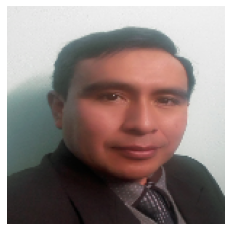

La suma total de las probabilidades es:  0.0030987833843880708
Primera prediccion:  No identificado  al  0.0 %
Segunda opción:  No identificado  al  0.0 %


In [0]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

image_path = './data05/prueba_final/erech.png'
imagen=load_img(image_path, target_size=(longitud, altura),color_mode="rgb") #"grayscale"   
#x.show() #Imprime el numero en una ventana

plt.imshow(imagen, cmap='gray_r')
plt.axis('off')
plt.show()

imagen=img_to_array(imagen)
imagen=np.expand_dims(imagen,axis=0)
imagen /= 255.

arreglo= modelo.predict(imagen)#PREDICCION  

prediccion_array=list(arreglo[0])
suma=0
for counter, value in enumerate(prediccion_array):
  prediccion_array[counter]=round(value,3)
  suma=suma+value

print("La suma total de las probabilidades es: ",suma)
n01,n02 = predicciones_nombres(prediccion_array,target_names_reducido,valor_minimo=0.05) 

#print('Etiquetas: ',target_names_reducido)
print("Primera prediccion: ",n01[0], " al ",n01[1]*100,"%")
print("Segunda opción: ",n02[0], " al ",n02[1]*100,"%")

Consulta a todo un directorio

In [0]:
import os
import os.path
direccion='./VGG16/Negativos/'
listaArchivos=os.listdir(direccion)
#print(listaArchivos)
Negativos_positivos=0
menor=100
for i, item in enumerate(listaArchivos):
  ruta=direccion+'/'+item
  imagen=load_img(ruta, target_size=(longitud, altura),color_mode="rgb")    
  imagen=img_to_array(imagen)
  imagen=np.expand_dims(imagen,axis=0)
  imagen /= 255.
  arreglo= modelo.predict(imagen)#PREDICCION
  prediccion_array=list(arreglo[0])
  n01,n02 = predicciones_nombres(prediccion_array,target_names_reducido,valor_minimo=0.05)
  print(item)
  print("Primera prediccion: ",n01[0], " al ",n01[1]*100,"%")
  print("Segunda Prediccion: ",n02[0], " al ",n02[1]*100,"%")
  print(i," ======================")
  if n01[1] < 0.15 :
    Negativos_positivos = Negativos_positivos +1
  if n01[1] < menor:
    menor=n01[1]
print("Negativos positivos: ",Negativos_positivos, "de: ",len(listaArchivos))
print("El menor valor de todos: ",menor*100," %")

UNAMBA_50972.jpeg
Primera prediccion:  No identificado  al  0.0 %
Segunda Prediccion:  No identificado  al  0.0 %
0  ======================
UNAMBA_147579.jpeg
Primera prediccion:  No identificado  al  0.0 %
Segunda Prediccion:  No identificado  al  0.0 %
1  ======================
UNAMBA_316929.jpeg
Primera prediccion:  No identificado  al  0.0 %
Segunda Prediccion:  No identificado  al  0.0 %
2  ======================
UNAMBA_31820.jpeg
Primera prediccion:  No identificado  al  0.0 %
Segunda Prediccion:  No identificado  al  0.0 %
3  ======================
UNAMBA_204311.jpeg
Primera prediccion:  No identificado  al  0.0 %
Segunda Prediccion:  No identificado  al  0.0 %
4  ======================
UNAMBA_1031.jpeg
Primera prediccion:  Sheyla_Zunilda_C.  al  10.38895845413208 %
Segunda Prediccion:  No identificado  al  0.0 %
5  ======================
UNAMBA_24921.jpeg
Primera prediccion:  No identificado  al  0.0 %
Segunda Prediccion:  No identificado  al  0.0 %
6  ======================
UN

<h1>Reportes y gráficos</h1>

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

x=validacion_generador.classes                         
cm = confusion_matrix(x, predicted)

In [0]:
df_cm = pd.DataFrame(cm,target_names_reducido, target_names_reducido) 
#plt.figure(figsize = (60,60))  #tamaño de la imagen longitud y altura
#sn.set(font_scale=0.8) # tamaño de las clases
#grafica=sn.heatmap(df_cm,cmap='Pastel1',annot=True, annot_kws={"size": 9},cbar=False)
#grafica.set(xlabel='Predicciones',ylabel='Datos Originales')
#plt.show()

In [0]:
#guardar la matriz de confusion
df_cm.to_csv('./denseUNAMBA_tensor2/matrizConfusion.csv')# guardar la matriz de conf

In [0]:
import pickle
import numpy as np 
import csv
reporte_clasif=classification_report(validacion_generador.classes, predicted, target_names=target_names_reducido,output_dict=True)
#reporte = pd.DataFrame(reporte_clasif,range(242),range(1))#,columns=['Names', 'Precision', 'Recall','F1-Score','Suport']) 

In [0]:
import pandas as pd

dataform=pd.DataFrame.from_dict(data=reporte_clasif).transpose()
dataform.to_csv('./denseUNAMBA_tensor2/reporteF.csv', header=reporte_clasif.keys()) 



---

